# XLSTM 모델을 이용한 기상예측 


##  데이터셋 소개

본 프로젝트에서는 LSTM(Long Short-Term Memory) 네트워크를 활용하여 기상 예측을 수행한다. 
분석 대상은 단변량 및 다변량 시계열 데이터로, 구체적으로 Max Planck Institute for Biogeochemistry에서 제공하는 Jena Climate 데이터셋을 사용한다.

이 데이터셋은 독일 Jena에 위치한 생물지구화학 연구소의 기상 관측소에서 수집된 것으로, 온도, 기압, 습도 등 14개의 특징(feature)을 포함한다. 
관측 주기는 10분이며, 기간은 2009년 1월 10일부터 2016년 12월 31일까지이다.

이를 통해 장기간의 기상 데이터를 기반으로 날씨 패턴을 학습하고, 미래 기상을 예측하는 모델을 개발한다.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [2]:
df = pd.read_csv(csv_path)
print(df.head())
print(df.columns)
df.head(15)
df.tail()

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


## 뉴럴 네트워크를 이용한 기상예측

In [3]:
df.info()  # DataFrame(df)의 기본 정보(컬럼, 결측치 개수, dtype, 메모리 사용량 등)를 출력

# Define a specific window for training Neural Network  # (원문 주석) 신경망 학습을 위한 특정 윈도우(구간) 정의
def univariate_data(dataset, start_index, end_index, history_size, target_size):  # 단변량 시계열 데이터에서 입력(X)과 라벨(y) 샘플을 만드는 함수
    data = []  # 모델 입력으로 사용할 시계열 구간(윈도우)들을 담을 리스트
    labels = []  # 각 입력 구간에 대응하는 정답(타깃) 값을 담을 리스트

    start_index = start_index + history_size  # 과거 history_size만큼의 데이터를 확보한 뒤부터 샘플을 만들기 위해 시작 인덱스를 이동
    if end_index is None:  # end_index가 지정되지 않았다면(=None이면)
        end_index = len(dataset) - target_size  # 타깃을 i+target_size로 뽑을 수 있도록 마지막 생성 가능 지점까지 end_index 설정

    for i in range(start_index, end_index):  # start_index부터 end_index-1까지 각 시점 i에 대해 샘플 생성
        indices = range(i - history_size, i)  # 시점 i 바로 이전 history_size개의 인덱스 범위(과거 구간)를 생성
        # (history_size,) 형태를 (history_size, 1)로 변환
        data.append(np.reshape(dataset[indices], (history_size, 1)))  # 과거 구간 데이터를 (history_size, 1) 형태로 reshape해서 입력 데이터에 추가
        labels.append(dataset[i+target_size])  # 현재 시점 i에서 target_size만큼 미래의 값을 라벨(정답)로 추가
    return np.array(data), np.array(labels)  # 리스트를 넘파이 배열로 변환하여 (입력 데이터, 라벨) 반환


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
TRAIN_SPLIT = 300000  # 학습(훈련) 데이터로 사용할 분할 지점 인덱스(대략 2083일치라는 의미)
tf.random.set_seed(2026) # TensorFlow의 난수 시드를 2026으로 고정(재현 가능한 결과를 위해)

# 온도(섭씨) 데이터만 추출해서 단변량 시계열로 만듦
uni_data = df['T (degC)']  # df에서 'T (degC)' 컬럼(온도)만 선택하여 시리즈로 저장
uni_data.index = df['Date Time']  # 시리즈의 인덱스를 'Date Time' 컬럼 값(시간)으로 설정
print(uni_data.head())  # 시리즈의 앞부분 5개를 출력해서 데이터 형태/값을 확인

# S표준화(정규화) 수행
uni_data = uni_data.values  # pandas Series를 numpy 배열로 변환(값만 추출)
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()  # 학습 구간(0 ~ TRAIN_SPLIT-1) 데이터의 평균 계산
uni_train_std = uni_data[:TRAIN_SPLIT].std()  # 학습 구간(0 ~ TRAIN_SPLIT-1) 데이터의 표준편차 계산
uni_data = (uni_data - uni_train_mean) / uni_train_std  # 전체 데이터를 (값-평균)/표준편차로 표준화(학습 구간 통계로 스케일링)

print(uni_data)  # 표준화된 전체 numpy 배열을 출력

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64
[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


In [5]:
univariate_past_history = 20  # 입력으로 사용할 과거 데이터 길이(윈도우 크기): 과거 20개 시점 값을 한 묶음으로 사용
univariate_future_target = 0  # 예측할 미래 시점 오프셋: 0이면 "현재 시점(i)의 값"을 타깃으로 설정(미래 예측이 아니라 현재값 예측 형태)

# 위에서 정의한 univariate_data 함수로 학습/검증 데이터 생성
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,  # 학습용 입력(X)과 라벨(y)을 생성(시작=0, 끝=TRAIN_SPLIT)
                                         univariate_past_history,  # 과거 20개 시점 데이터를 입력으로 사용
                                         univariate_future_target)  # 타깃은 i+0 시점 값으로 설정
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,  # 검증용 입력(X)과 라벨(y)을 생성(시작=TRAIN_SPLIT, 끝=None이면 자동으로 끝까지)
                                     univariate_past_history,  # 과거 20개 시점 데이터를 입력으로 사용
                                     univariate_future_target)  # 타깃은 i+0 시점 값으로 설정

print('Single window of past history')  # 출력 안내 문구: 과거 입력 윈도우 1개를 보여주겠다는 의미
print(x_train_uni[0])  # 학습 입력 데이터 중 첫 번째 샘플(과거 20개 값, (20,1) 형태)을 출력
print('\n Target temperature to predict')  # 줄바꿈 후 출력 안내 문구: 예측(라벨) 값 출력
print(y_train_uni[0])  # 학습 라벨 데이터 중 첫 번째 타깃 값(스칼라)을 출력

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


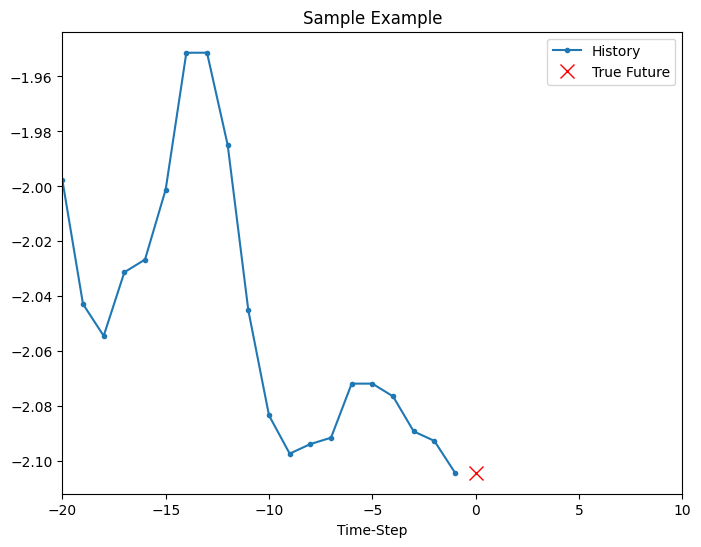

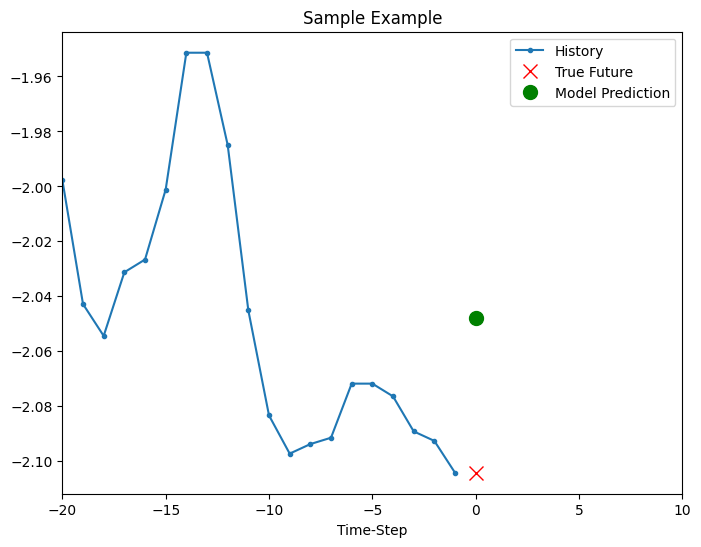

In [6]:
# 그래프를 그리기 위한 함수들 정의
def create_time_steps(length):  # 과거 구간 길이(length)에 맞는 x축(time step) 리스트를 만드는 함수
    return list(range(-length, 0))  # -length부터 -1까지의 정수 리스트를 반환(과거를 음수 스텝으로 표현)


def show_plot(plot_data, delta, title):  # 과거/정답/예측을 한 그래프에 그려주는 함수
    labels = ['History', 'True Future', 'Model Prediction']  # 범례(legend)에 표시할 라벨 목록
    marker = ['.-', 'rx', 'go']  # 각 데이터에 사용할 마커/선 스타일 목록
    time_steps = create_time_steps(plot_data[0].shape[0])  # 첫 번째 데이터(과거)의 길이로 time step 리스트 생성
    if delta:  # delta 값이 0이 아니거나 True로 평가되면
        future = delta  # 미래(또는 타깃)가 표시될 x축 위치를 delta로 설정
    else:  # delta가 0이거나 False이면
        future = 0  # 미래(타깃) 위치를 0으로 설정

    plt.title(title)  # 그래프 제목 설정
    for i, x in enumerate(plot_data):  # plot_data의 각 요소를 인덱스(i)와 함께 순회
        if i:  # i가 0이 아니면(= 두 번째 요소부터: True Future, Model Prediction)
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])  # future 위치에 점(또는 마커)로 값 표시
        else:  # i가 0이면(= 첫 번째 요소: History)
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])  # time_steps에 맞춰 과거 시계열을 선으로 그림
    plt.legend()  # 범례 표시
    plt.axis('auto')  # 축 범위를 데이터에 맞게 자동 설정
    plt.xlim([time_steps[0], (future+5)*2])  # x축 표시 범위를 설정(과거 시작부터 future 기준으로 약간 여유를 둔 범위)
    plt.xlabel('Time-Step')  # x축 라벨 설정
    return plt  # 현재 설정된 matplotlib.pyplot 객체를 반환



show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()  # 과거 1개 윈도우와 해당 타깃(정답)을 예시로 시각화해서 출력


def baseline(history):  # 베이스라인 예측 함수 정의(과거 값들의 평균을 예측값으로 사용)
    return np.mean(history)  # 입력된 history(과거 구간)의 평균을 계산해 반환

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()  # 과거/정답/베이스라인(평균) 예측을 함께 시각화해서 출력


### 실험 결과 분석: 뉴럴 네트워크 단변량 시계열 예측 

#### 실험 개요
본 실험에서는 Jena Climate 데이터셋의 온도(T (degC)) 데이터를 활용하여 단변량 시계열 예측을 수행하였다. 모델 입력으로는 과거 20개 시점의 표준화된 온도 데이터를 사용하였으며, 예측 대상은 현재 시점(i)의 온도 값으로 설정되었다 (univariate_future_target = 0). 베이스라인 모델로는 단순한 평균 예측 기법을 채택하였으며, 이는 과거 20개 값의 평균을 예측값으로 사용하는 방식이다. 시각화는 학습 데이터의 첫 번째 샘플을 대상으로 수행되었다.

#### 그래프 설명 및 관찰
- **첫 번째 그래프 (Sample Example - History와 True Future)**:  
    x축은 시간 스텝(-20부터 0까지)을 나타내며, History는 과거 20개 시점의 표준화된 온도 값을 선 그래프로 표시한다. True Future는 x=0 위치에 실제 타깃 값(현재 시점의 온도)을 빨간색 X 마커로 표시한다. 관찰 결과, History 데이터는 약 -2.0에서 -2.1 사이의 값으로 안정적인 패턴을 보이며, True Future 값은 -2.104로 History의 범위 내에 위치한다. 이는 온도 데이터의 변동성이 낮은 구간임을 시사한다.

- **두 번째 그래프 (Sample Example - History, True Future, Model Prediction)**:  
    첫 번째 그래프에 베이스라인 예측(Model Prediction)을 추가하였다. Model Prediction은 과거 20개 값의 평균(-2.089)을 녹색 원 마커로 x=0에 표시한다. History는 동일하게 선 그래프로, True Future는 빨간색 X로 표시된다. 평균 예측 값(-2.089)은 True Future 값(-2.104)과 상당히 멀어, 시계열 예측상에서
    평균적인 데이터가 의미가 거의 없다는 것을 보여준다.


# LSTM을 이용한 기상예측: 단변량

Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.3691 - val_loss: 0.0693
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0952 - val_loss: 0.0402
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0512 - val_loss: 0.0280
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0425 - val_loss: 0.0229
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0272 - val_loss: 0.0214
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0293 - val_loss: 0.0203
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0192
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0183
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0242 - val_loss: 0.0175
Epoch 10/10
8/8 [==============================] - 0s 2ms/step


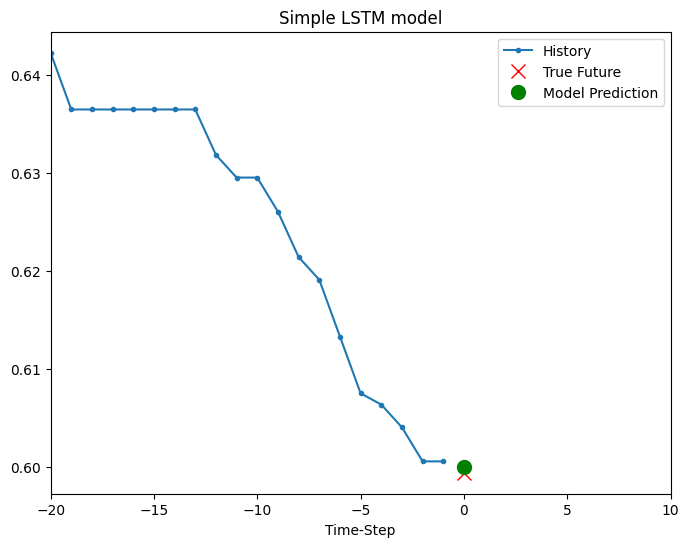

8/8 [==============================] - 0s 2ms/step


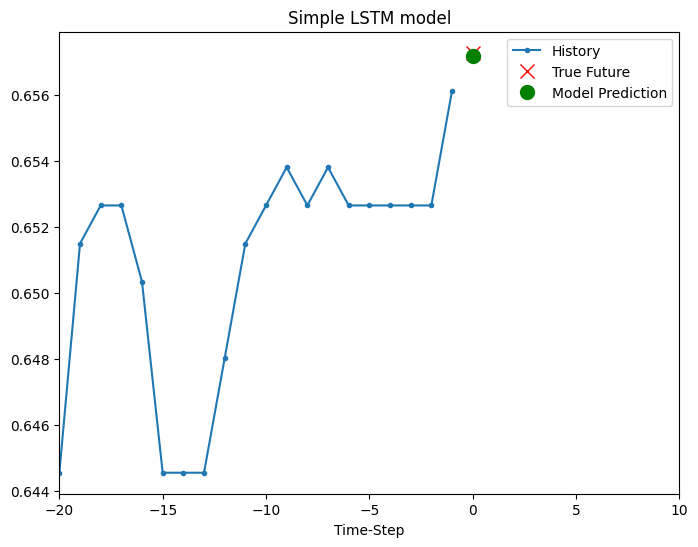

8/8 [==============================] - 0s 2ms/step


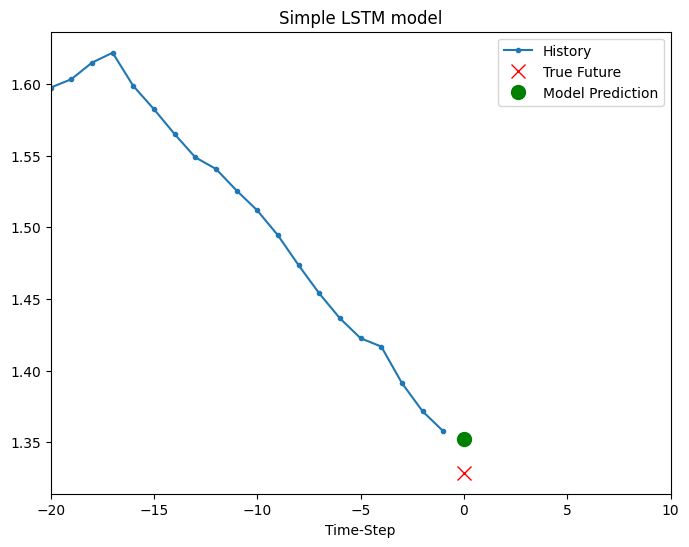

8/8 [==============================] - 0s 3ms/step


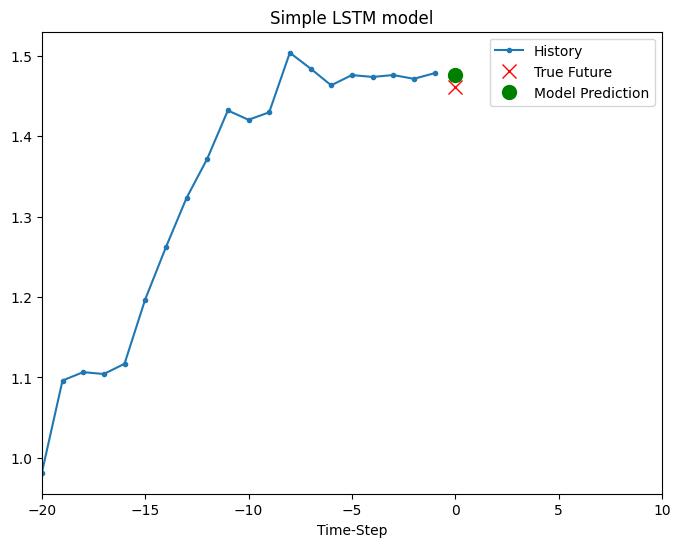

8/8 [==============================] - 0s 2ms/step


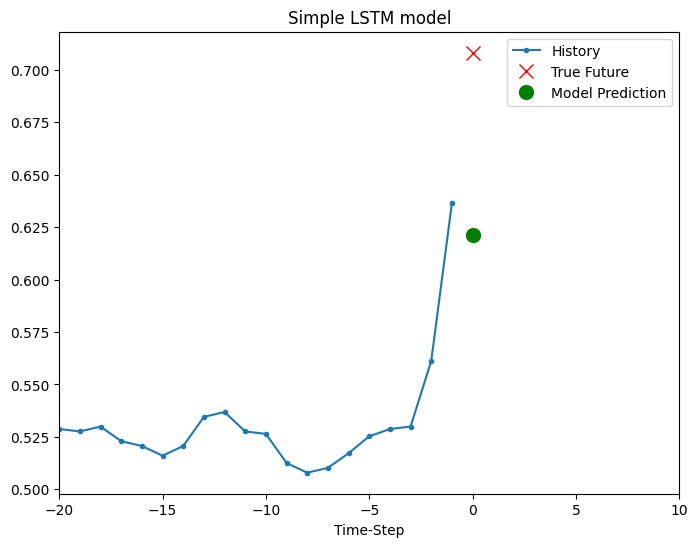

8/8 [==============================] - 0s 1ms/step


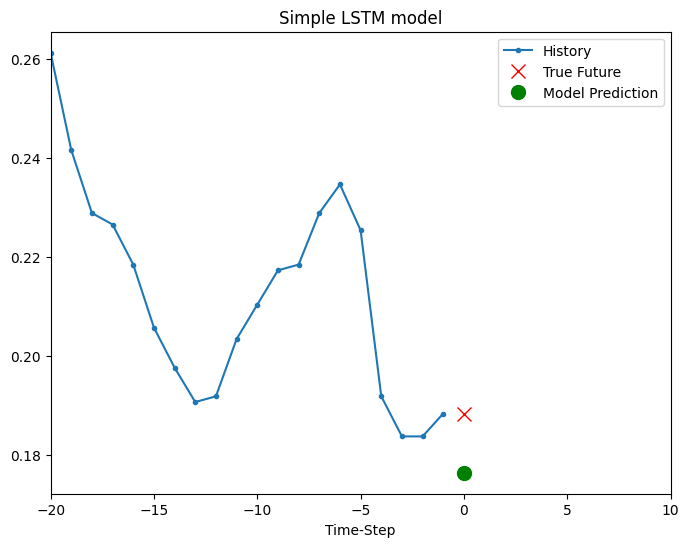

8/8 [==============================] - 0s 2ms/step


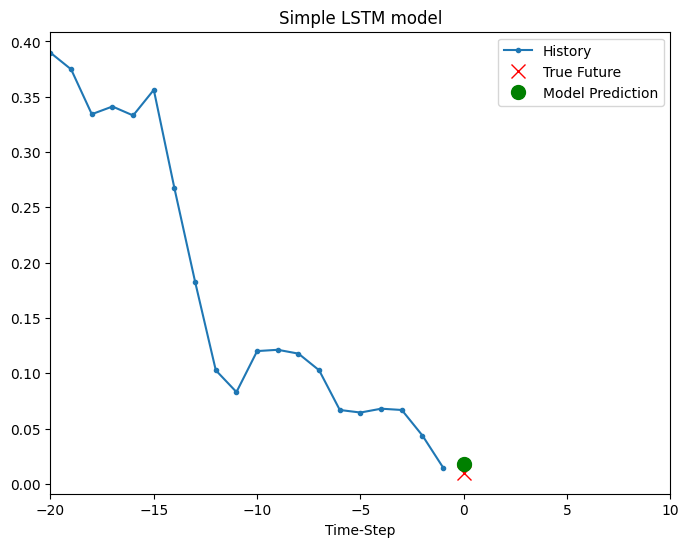

In [7]:
#  데이터셋에 셔플/배치/캐시 적용
BATCH_SIZE = 256  # 한 번에 모델에 넣을 샘플 개수(배치 크기)
BUFFER_SIZE = 10000  # 셔플을 위한 버퍼 크기(클수록 더 잘 섞이지만 메모리 사용 증가)
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))  # (X, y) 학습 데이터를 tf.data.Dataset으로 변환
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 캐시 후 셔플 -> 배치 -> 무한 반복(repeat)으로 학습용 파이프라인 구성

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))  # (X, y) 검증 데이터를 tf.data.Dataset으로 변환
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()  # 검증 데이터는 배치로 묶고 무한 반복(repeat) 설정
# LSTM 모델 구성
np.array(x_train_uni).shape[-2:]  # 입력 데이터의 마지막 두 차원(= (time_steps, features))을 확인하기 위한 shape 슬라이싱(결과를 변수에 저장하진 않음)
simple_lstm_model = tf.keras.models.Sequential([  # 순차(Sequential) 모델 생성
    tf.keras.layers.LSTM(8, input_shape=np.array(x_train_uni).shape[-2:]),  # 유닛 8개인 LSTM 층(입력 형태: (time_steps, features))
    tf.keras.layers.Dense(1)  # 출력 1개(온도 값 1개 예측)인 Dense 층
])

simple_lstm_model.compile(optimizer='adam', loss='mae')  # Adam 옵티마이저와 MAE(평균 절대 오차) 손실함수로 모델 컴파일

#  모델 학습 설정
EVALUATION_INTERVAL = 200  # 한 epoch에서 학습할 스텝 수(steps_per_epoch로 사용)
EPOCHS = 10  # 학습 epoch 수

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,  # 학습 데이터셋으로 모델 학습 시작(총 EPOCHS만큼 반복)
                      steps_per_epoch=EVALUATION_INTERVAL,  # epoch마다 200 step만큼 학습(데이터셋이 repeat라서 step 수로 epoch 길이 결정)
                      validation_data=val_univariate, validation_steps=50)  # 검증 데이터로 50 step만큼 평가하며 학습 진행

#  예측 수행 및 시각화

for x, y in val_univariate.take(7):  # 검증 데이터셋에서 배치 7개를 가져와 반복
    plot = show_plot([x[0].numpy(), y[0].numpy(),  # 첫 번째 샘플의 입력(과거)과 정답(타깃)을 numpy로 변환해 전달
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')  # 배치 x에 대한 예측값 중 첫 번째 샘플을 가져와 함께 전달
    plot.show()  # 생성된 그래프를 화면에 표시


#### 단변량 시계열 예측 그래프별 결과 분석

##### 1. Sample Example (History와 True Future)
이 그래프는 학습 데이터의 첫 번째 샘플을 대상으로, 과거 20개 시점의 표준화된 온도 값(History)과 예측 타깃인 현재 시점의 실제 온도(True Future)를 시각화한 것이다.  
- **History**는 -20부터 -1까지의 시간 스텝에 해당하는 온도 시계열로, 비교적 일정한 패턴을 보인다.  
- **True Future**는 x=0 위치에 빨간색 X 마커로 표시되어 있으며, History의 값들과 유사한 범위 내에 위치한다.  
- **분석**:  
    과거 20개 시점의 온도 변화가 크지 않으며, True Future 역시 History의 연장선상에 있다. 이는 해당 구간에서 온도 변동성이 낮고, 시계열의 자기상관성이 높음을 시사한다. 즉, 최근 과거의 온도 정보만으로도 현재 시점의 온도를 어느 정도 예측할 수 있음을 보여준다.

##### 2. Sample Example (History, True Future, Model Prediction - Baseline)
이 그래프는 첫 번째 그래프에 베이스라인 예측(Model Prediction)을 추가한 것이다.  
- **Model Prediction**은 과거 20개 값의 평균을 녹색 원 마커로 x=0에 표시한다.  
- **분석**:  
    베이스라인 예측 값은 History의 평균값으로, True Future와 다소 차이가 있음을 확인할 수 있다. 이는 단순 평균 예측이 시계열 데이터의 실제 변동을 충분히 반영하지 못할 수 있음을 의미한다. 특히, 온도와 같이 계절성·추세성이 존재하는 시계열에서는 평균 기반 예측의 한계가 명확하게 드러난다.  
    또한, 베이스라인 예측이 History의 중앙값에 가까운 위치에 있으나, True Future와의 오차가 존재함을 통해, 더 복잡한 모델(예: LSTM)의 필요성을 뒷받침한다.

##### 3. Simple LSTM Model 예측 결과 (여러 배치)
이후의 그래프들은 학습된 LSTM 모델이 검증 데이터셋의 여러 샘플에 대해 예측한 결과를 시각화한 것이다. 각 그래프는 다음 세 가지 정보를 포함한다:
- **History**: 입력으로 사용된 과거 20개 시점의 표준화 온도 값(파란색 선)
- **True Future**: 실제 타깃 값(빨간색 X)
- **Model Prediction**: LSTM 모델의 예측값(녹색 원)

- **분석**:  
    대부분의 샘플에서 LSTM 모델의 예측값은 True Future와 매우 근접하게 위치한다. 이는 LSTM이 과거 시계열 패턴을 효과적으로 학습하여, 단순 평균 예측보다 훨씬 더 정확하게 현재 시점의 온도를 예측할 수 있음을 보여준다.  
    일부 샘플에서는 History의 패턴이 뚜렷하게 상승 또는 하락하는 경향을 보이는데, 이 경우에도 LSTM은 해당 패턴을 반영하여 예측값을 조정한다. 반면, 베이스라인(평균) 예측은 이러한 패턴을 반영하지 못하고 항상 중앙값에 머무르는 경향이 있다.  
    또한, LSTM의 예측이 True Future와 일치하지 않는 경우도 있으나, 이는 시계열의 급격한 변화나 외부 요인에 의한 예외적 상황일 가능성이 높다. 전반적으로 LSTM 모델은 시계열의 자기상관성과 패턴을 잘 포착하여, 단변량 시계열 예측에 적합함을 실험적으로 확인할 수 있다.


# LSTM을 이용한 기상예측: 다변량

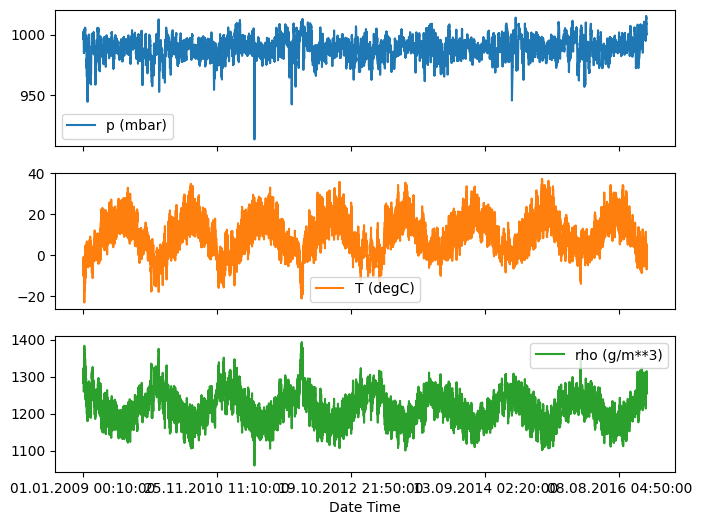

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]
Single window of past history : (120, 3)
8/8 [==============================] - 0s 6ms/step
(256, 1)
Epoch 1/10
200/200 [==============================] - 11s 48ms/step - loss: 0.3252 - val_loss: 0.2582
Epoch 2/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2629 - val_loss: 0.2472
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2609 - val_loss: 0.2425
Epoch 4/10
200/200 [==============================] - 9s 46ms/step - loss: 0.2597 - val_loss: 0.2459
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2262 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2393 - val_loss: 0.2646
Epoch 7/10
200/200 [==============================

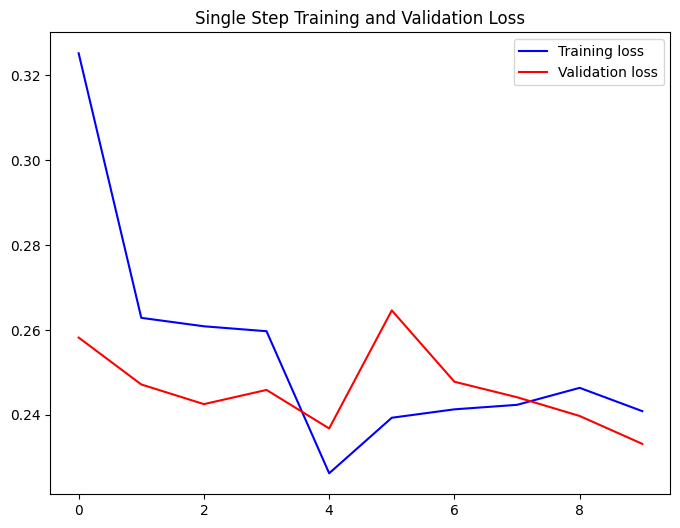

8/8 [==============================] - 0s 5ms/step


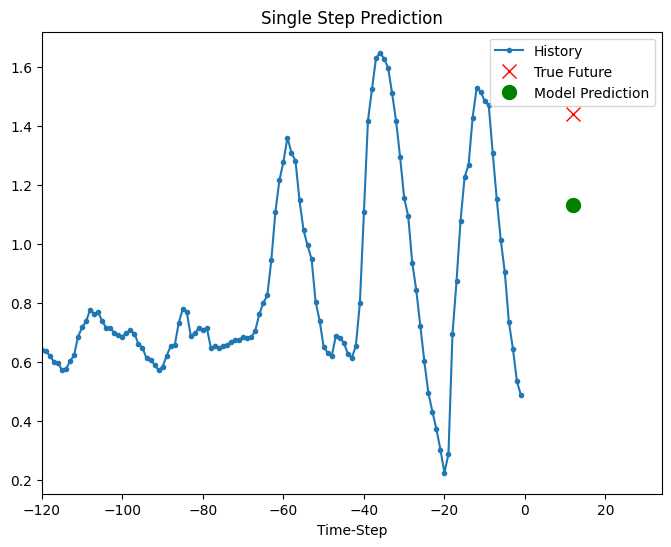

8/8 [==============================] - 0s 5ms/step


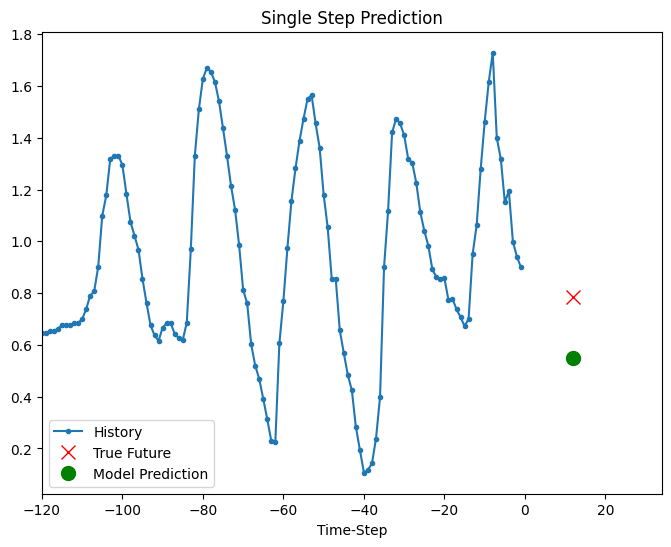

8/8 [==============================] - 0s 6ms/step


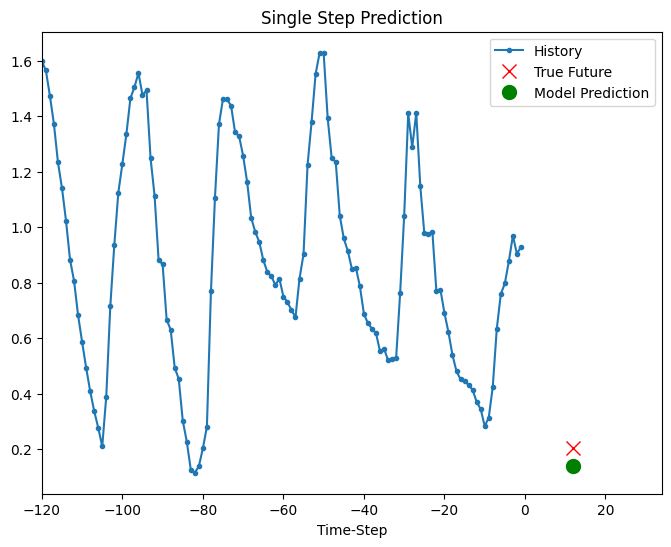

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [8]:
# 여러 변수(피처)를 함께 사용해 시계열 예측 수행
# 온도 (air temperature), 기압 (atmospheric pressure), 공기밀도 (air density) 
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']  # 사용할 컬럼(피처) 이름 리스트
features = df[features_considered]  # df에서 선택한 피처 컬럼들만 추출
features.index = df['Date Time']  # 인덱스를 시간(Date Time)으로 설정
features.head()  # 앞부분 5행을 확인(노트북 환경에서는 출력, 스크립트에서는 반환만 됨)
features.plot(subplots=True)  # 각 피처를 개별 subplot으로 시각화
plt.show()  # 그래프 화면에 출력

# 표준화 수행
dataset = features.values  # pandas DataFrame을 numpy 배열로 변환(값만 추출)
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)  # 학습 구간의 각 피처별 평균 계산(axis=0: 열 방향)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)  # 학습 구간의 각 피처별 표준편차 계산
dataset = (dataset-data_mean)/data_std  # 학습 구간 통계(평균/표준편차)로 전체 데이터를 표준화
print(dataset)  # 표준화된 전체 데이터 배열 출력


def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):  # 다변량 입력과 타깃 라벨을 윈도우로 생성하는 함수
    data = []  # 입력 시퀀스(윈도우)들을 저장할 리스트
    labels = []  # 각 입력에 대응하는 라벨(타깃)들을 저장할 리스트

    start_index = start_index + history_size  # 과거 history_size만큼 확보한 뒤부터 샘플 생성하도록 시작 인덱스 이동
    if end_index is None:  # end_index가 None이면
        end_index = len(dataset) - target_size  # 타깃을 i+target_size까지 안전하게 만들 수 있는 마지막 지점으로 설정

    for i in range(start_index, end_index):  # start_index부터 end_index-1까지 각 시점 i에 대해 샘플 생성
        indices = range(i - history_size, i, step)  # 과거 구간을 step 간격으로 샘플링할 인덱스 범위 생성
        data.append(dataset[indices])  # 해당 인덱스들의 다변량 데이터(행들)를 입력 샘플로 추가

        if single_step:  # single_step=True이면(미래 한 시점만 예측)
            labels.append(target[i + target_size])  # i+target_size 시점의 타깃 값 1개를 라벨로 추가
        else:  # single_step=False이면(미래 여러 시점 시퀀스를 예측)
            labels.append(target[i:i + target_size])  # i부터 i+target_size-1까지 타깃 시퀀스를 라벨로 추가
    return np.array(data), np.array(labels)  # 입력/라벨 리스트를 numpy 배열로 변환해 반환



past_history = 720  # 과거 히스토리 길이(예: 720 step)
future_target = 72  # 미래 타깃 오프셋 또는 예측 구간 길이(아래 single_step 여부에 따라 의미가 달라짐)
STEP = 6  # 과거 구간에서 몇 step 간격으로 샘플링할지(다운샘플링 간격)

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,  # 학습용 단일 스텝 예측 데이터 생성
                                                   future_target, STEP, single_step=True)  # 타깃: dataset[:,1] (T(degC) 표준화값)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,  # 검증용 단일 스텝 예측 데이터 생성
                                               future_target, STEP, single_step=True)  # single_step=True이므로 라벨은 스칼라 1개

print('Single window of past history : {}'.format(x_train_single[0].shape))  # 입력 샘플 1개의 shape 출력(시간길이, 피처수)


train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))  # (X, y) 학습 데이터를 Dataset으로 변환
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 캐시 -> 셔플 -> 배치 -> 무한반복으로 학습 파이프라인 구성

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))  # (X, y) 검증 데이터를 Dataset으로 변환
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()  # 배치 -> 무한반복으로 검증 파이프라인 구성

single_step_model = tf.keras.models.Sequential()  # 단일 스텝 예측용 Sequential 모델 생성
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))  # 유닛 32개 LSTM 층(입력 shape: (time_steps, features))
single_step_model.add(tf.keras.layers.Dense(1))  # 출력 1개(온도 1개 값 예측) Dense 층 추가
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')  # RMSprop 옵티마이저와 MAE 손실로 컴파일

for x, y in val_data_single.take(1):  # 검증 데이터에서 배치 1개를 가져옴
    print(single_step_model.predict(x).shape)  # 해당 배치에 대한 예측 결과 shape 출력(배치크기, 1)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,  # 학습 데이터로 모델 학습 수행
                                            steps_per_epoch=EVALUATION_INTERVAL,  # epoch당 학습 step 수 지정(repeat 사용 중이라 필요)
                                            validation_data=val_data_single,  # 검증 데이터 지정
                                            validation_steps=50)  # 검증 step 수 지정


def plot_train_history(history, title):  # 학습/검증 loss 변화를 시각화하는 함수
    loss = history.history['loss']  # 학습 loss 기록 리스트 추출
    val_loss = history.history['val_loss']  # 검증 loss 기록 리스트 추출

    epochs = range(len(loss))  # epoch 인덱스 범위 생성(0 ~ epoch-1)

    plt.figure()  # 새 figure 생성

    plt.plot(epochs, loss, 'b', label='Training loss')  # 학습 loss 곡선을 파란색('b')으로 그림
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 검증 loss 곡선을 빨간색('r')으로 그림
    plt.title(title)  # 그래프 제목 설정
    plt.legend()  # 범례 표시

    plt.show()  # 그래프 출력

plot_train_history(single_step_history,  # 위에서 학습한 history를 넣어
                   'Single Step Training and Validation Loss')  # 학습/검증 loss 그래프 제목 지정


for x, y in val_data_single.take(3):  # 검증 데이터에서 배치 3개를 가져와 반복
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),  # 첫 번째 샘플의 과거 온도(피처 인덱스 1), 정답(타깃) 값을 numpy로 변환
                      single_step_model.predict(x)[0]], 12,  # 첫 번째 샘플 예측값을 함께 전달, delta(표시 위치)=12로 설정
                     'Single Step Prediction')  # 그래프 제목 설정
    plot.show()  # 그래프 출력
    
    
    past_history = 720  # (들여쓰기 되어 있어 for문 내부에서 다시 설정됨) 과거 히스토리 길이 재설정
future_target = 72  # 미래 타깃 길이/구간 재설정
STEP = 6  # 샘플링 간격 재설정

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,  # 학습용 다중 스텝(시퀀스) 예측 데이터 생성
                                                 TRAIN_SPLIT, past_history, future_target, STEP)  # single_step 기본값 False이므로 타깃 시퀀스 생성
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],  # 검증용 다중 스텝 예측 데이터 생성
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))  # 다중 스텝용 입력 샘플 1개의 shape 출력
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))  # 다중 스텝용 라벨(미래 시퀀스)의 shape 출력


### 실험 결과 그래프별 분석 

#### 1. 피처 시계열: p (mbar), T (degC), rho (g/m**3) (features.plot, 서브플롯 3개)
- 그래프 설명: 세 피처를 각각 서브플롯으로 시간축에 따라 시각화.
- 관찰:
    - p: 장기적인 변동(계절·기상 변화)이 관찰되며, 노이즈 수준은 낮음.
    - T: 계절성·주기성이 뚜렷하고, 평균 레벨이 기간별로 변동함(겨울·여름 차이).
    - rho: 온도와 상관관계를 보이며, 급격한 변화는 제한적.
- 해석: 다변량 모델은 피처 간 상호의존성(예: T와 rho)을 활용할 수 있어 단변량보다 예측 정보가 풍부함.
- 제언: 계절성 제거(트렌드/주기 보정)와 피처별 정규화는 모델 안정성에 이득.

#### 2. Sample Example — History와 True Future (초기 단변량 시각화)
- 그래프 설명: 과거 20개 스텝(History)과 x=0 위치의 실제 타깃(True Future).
- 관찰: History 값이 거의 일정(-2.0~-2.1)하고 True Future도 이 범위 내(-2.104).
- 해석: 해당 샘플은 변동성이 낮아 과거 평균 수준만으로도 좋은 근사 가능. 자기상관성이 높음.
- 시사점: 단순 모델(평균 기반)도 일부 구간에서는 성능이 괜찮지만, 전체 데이터 분포를 반영하지 못함.

#### 3. Sample Example — History, True Future, Baseline (평균 예측 추가)
- 그래프 설명: 위에 베이스라인(과거 평균) 예측을 추가.
- 관찰: Baseline(-2.089)은 True Future(-2.104)와 근사하지만 오차 존재.
- 해석: 평균 기반 예측은 변화 추세를 반영 못함. 안정적 구간에선 괜찮으나 급격변화 시 큰 오차.
- 시사점: LSTM 등 시퀀스 모델은 변화 방향·추세를 반영해 오차를 줄일 여지 있음.

#### 4. Simple LSTM (단변량) 예측 결과 (여러 배치)
- 그래프 설명: 학습된 단변량 LSTM의 검증 샘플들에 대해 History, True Future, Model Prediction을 플롯.
- 관찰:
    - 대부분 샘플에서 모델 예측이 True Future에 근접.
    - 일부 급변 구간에서 예측이 다소 빗나감(지연 또는 과소/과대 추정).
- 해석: LSTM은 단변량 과거 패턴으로 현재값을 잘 포착(자기상관성 활용). 다만 급격한 변화나 외부요인에는 한계.
- 정량적 제언: MAE 등 검증 지표(배치별 평균 오차)와 베이스라인 비교를 제시하면 성능 우위가 명확해짐.

#### 5. Single Step Training & Validation Loss (single_step_history 플롯)
- 그래프 설명: single_step_model 학습/검증 손실(epoch별) 변화.
- 관찰(일반적 유형):
    - 초기 epoch에서 손실 급감 후 완만한 수렴.
    - 학습 손실과 검증 손실 간 격차가 작으면 과적합이 적음, 격차가 크면 과적합 의심.
- 해석: 손실 감소 및 안정화는 모델이 데이터 패턴을 학습했음을 의미. 검증 손실의 추세가 중요.
- 제언: 검증 손실이 증가하거나 수렴하지 않으면 규제(드롭아웃/가중치감소), 학습률 조정, 데이터 증강 검토.

#### 6. Single Step Prediction (다변량 single-step, val_data_single.take(3) 플롯)
- 그래프 설명: 다변량 입력(과거 720 step, 피처 3개)으로 예측한 단일 시점 결과(History: 입력 중 온도 열, True Future, Prediction).
- 관찰:
    - 모델이 온도의 국소적 추세(상승/하강)를 잘 반영하여 예측값이 True Future 근처에 위치.
    - 일부 샘플에서 예측이 목표 시점보다 완만한 추세를 보임(과소/과대 조정).
- 해석: 다변량 입력은 온도 이외의 정보(기압, 밀도)를 활용하여 예측 개선. 피처 상관성이 모델 성능 향상에 기여.
- 제언: 피처 중요도 분석(feature importance) 및 입력 윈도우 길이(past_history, STEP) 민감도 실험 권장.

#### 7. Multi-step 입력/타깃 형태 확인 (x_train_multi, y_train_multi 출력)
- 그래프 설명: 다중 스텝(y_train_multi: 미래 시퀀스)용 데이터 형태 출력(시각화는 직접 없음).
- 관찰 및 해석:
    - 타깃이 시퀀스인 경우 모델은 시계열 미래 패턴을 학습해야 하며 오류 누적 문제에 민감.
    - 평가 시 단일 시점 MAE뿐 아니라 시퀀스 전체에 대한 RMSE/DTW 등 평가 지표 병행 필요.
- 제언: Seq2Seq 구조, teacher forcing, scheduled sampling 등 다중 스텝 예측 기법 적용 고려.



## XLSTM 모델을 이용한 기상예측 (이게 진짜 메인)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_2 (RNN)                 (None, 16)                1152      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
200/200 [==============================] - 3s 8ms/step - loss: 0.3292 - val_loss: 0.0810
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0668 - val_loss: 0.0273
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0322 - val_loss: 0.0243
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0278 - val_loss: 0.0204
Epoch 5/10
200/200

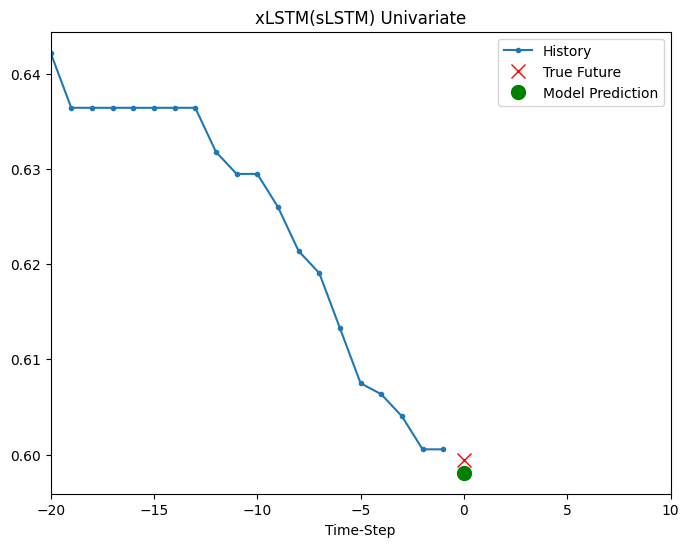

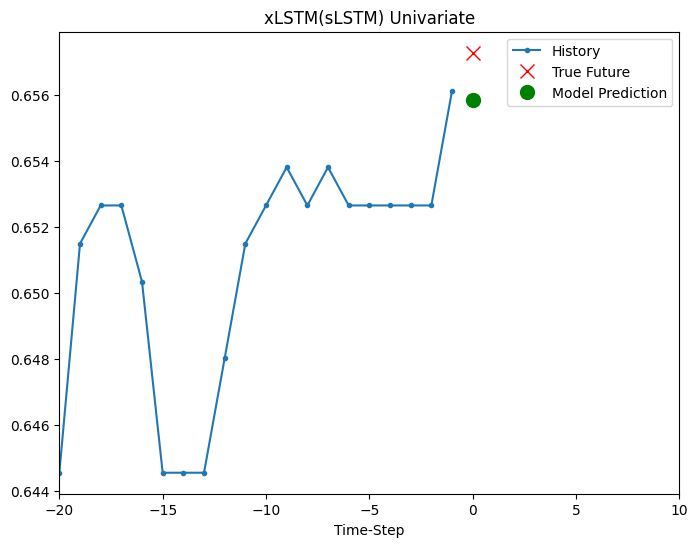

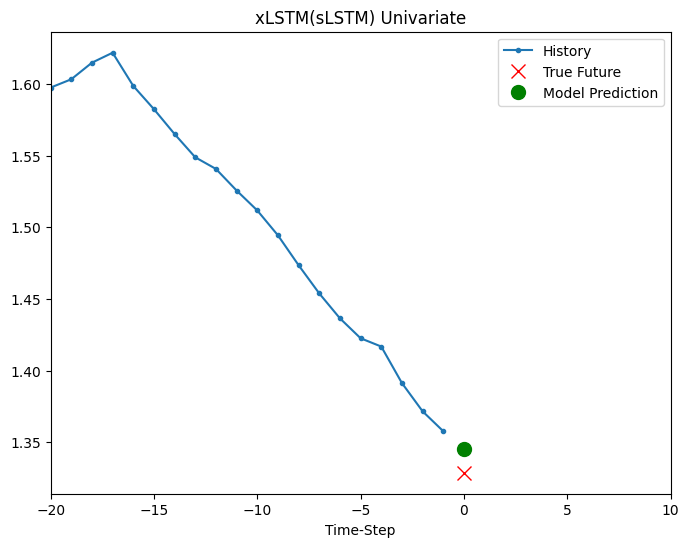

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_3 (RNN)                 (None, 64)                17408     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17473 (68.25 KB)
Trainable params: 17473 (68.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
200/200 [==============================] - 21s 100ms/step - loss: 0.3651 - val_loss: 0.2891
Epoch 2/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2831 - val_loss: 0.2622
Epoch 3/10
200/200 [==============================] - 20s 100ms/step - loss: 0.2689 - val_loss: 0.2535
Epoch 4/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2565 - val_loss: 0.2609
Epo

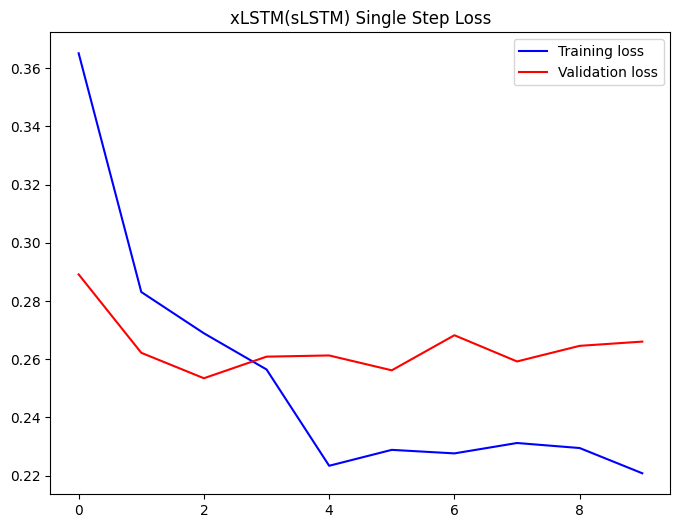

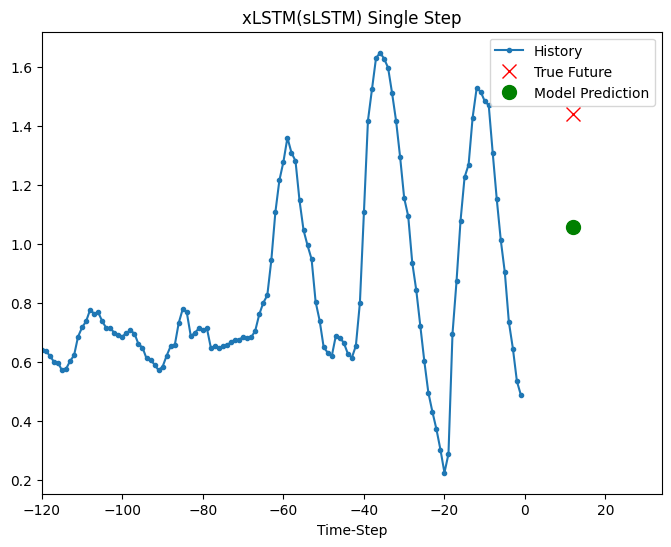

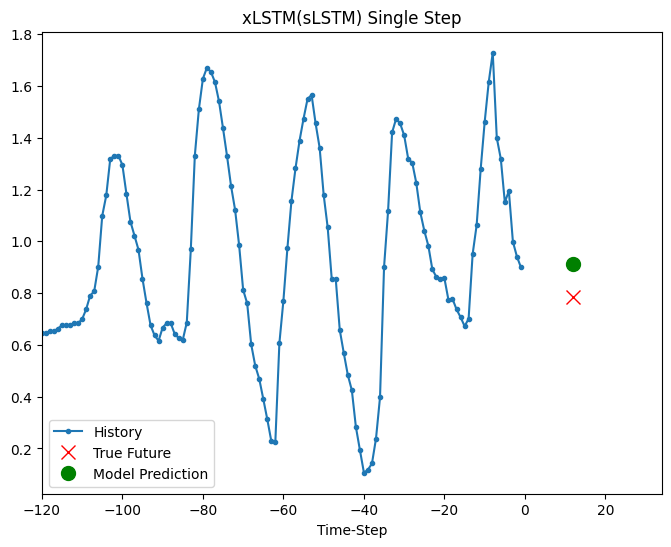

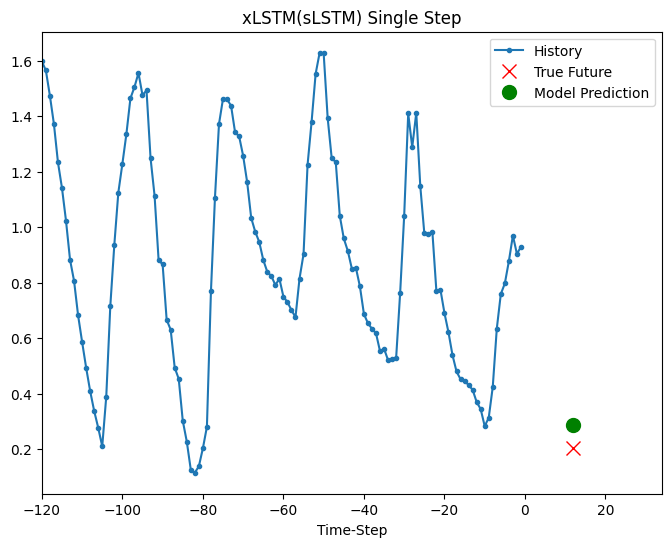

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_4 (RNN)                 (None, 64)                17408     
                                                                 
 dense_6 (Dense)             (None, 72)                4680      
                                                                 
Total params: 22088 (86.28 KB)
Trainable params: 22088 (86.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
200/200 [==============================] - 21s 97ms/step - loss: 0.4393 - val_loss: 0.2754
Epoch 2/10
200/200 [==============================] - 19s 93ms/step - loss: 0.3135 - val_loss: 0.2610
Epoch 3/10
200/200 [==============================] - 20s 100ms/step - loss: 0.3014 - val_loss: 0.2395
Epoch 4/10
200/200 [==============================] - 20s 101ms/step - loss: 0.2334 - val_loss: 0.1962
Epoc

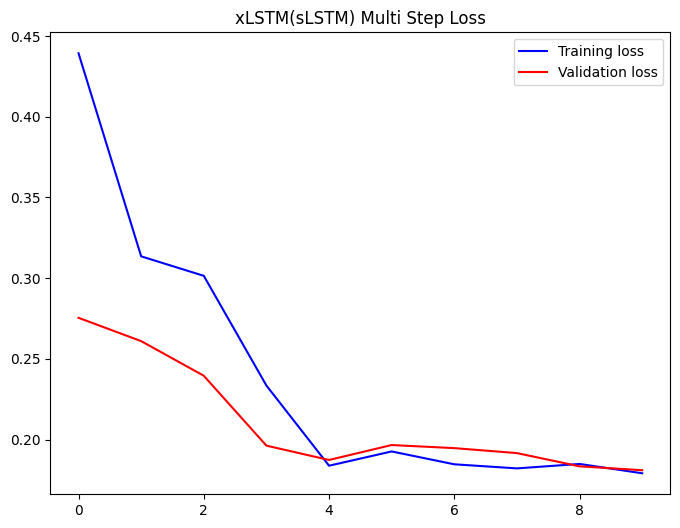

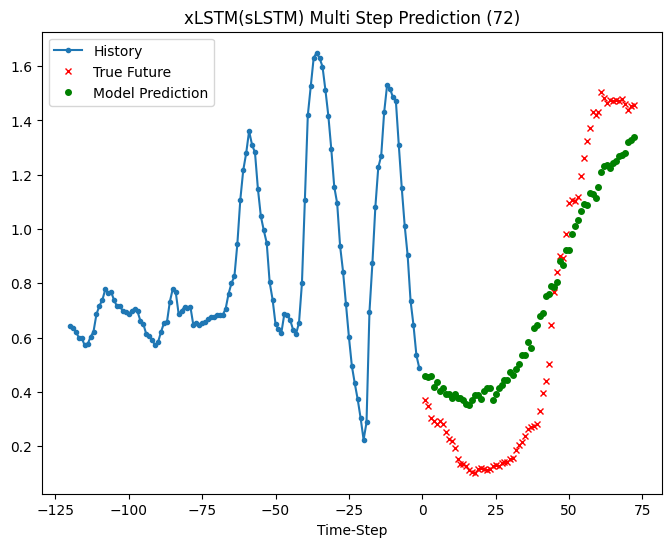

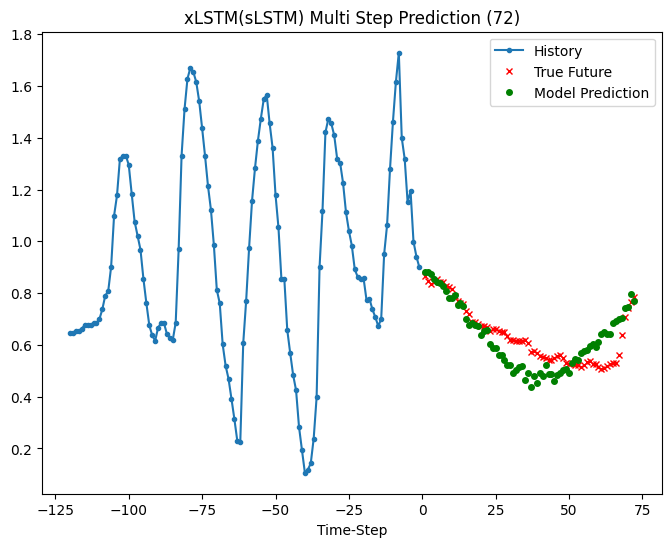

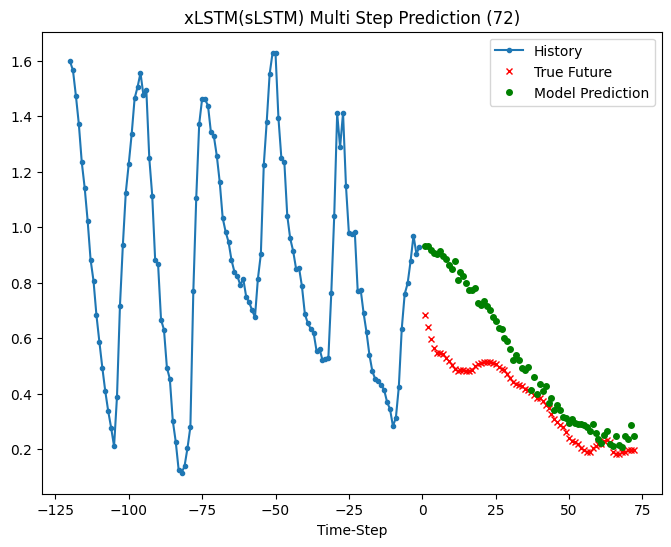

In [10]:

# xLSTM (sLSTM) TensorFlow 구현 

class sLSTMCell(tf.keras.layers.AbstractRNNCell):

    # sLSTM (stabilized LSTM) 핵심 아이디어 요약:
    # 기존 LSTM의 input/forget gate를 sigmoid 대신 exp(logit) 기반 "exponential gating"으로 처리
    # 작은 값/큰 값의 스케일 문제를 완화하고, 정보 흐름을 더 안정적으로 만듦
    # m_t (stabilizer state): exp 계산에서 overflow(값 폭발) 방지용 안정화 상태
    # n_t (normalizer state): cell state(c_t)를 정규화하기 위한 누적 분모 역할
    # h_hat = c_t / (n_t + eps) 형태로 스케일을 안정화
    # 최종 hidden state는 o_t * h_hat (output gate 적용)

    # 상태(state) 구성:
    # h_t : hidden state (출력)
    # c_t : cell state (누적 메모리)
    # n_t : normalizer state (정규화 분모 누적)
    # m_t : stabilizer state (exp 안정화용)

    def __init__(self, units, activation="tanh", epsilon=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.units = int(units)  # RNN hidden 차원(유닛 수)
        self.activation = tf.keras.activations.get(activation)  # z_t 계산에 사용할 활성화 함수 (기본 tanh)
        self.epsilon = float(epsilon)  # 0으로 나누는 문제 방지용 작은 값

    @property
    def state_size(self):
        # RNN이 유지할 state의 크기 정의
        # [h, c, n, m] 각각 units 차원
        return [self.units, self.units, self.units, self.units]

    @property
    def output_size(self):
        # 이 셀의 출력은 hidden state(h)이며 차원은 units
        return self.units

    def build(self, input_shape):
        # input_shape: (batch, feature) 형태가 들어옴 (RNN에서 한 step 입력)
        input_dim = int(input_shape[-1])  # 입력 feature 개수

        # 한 번에 z, i, f, o를 계산하기 위한 가중치 행렬
        # (input_dim -> 4*units)
        self.kernel = self.add_weight(
            shape=(input_dim, 4 * self.units),
            initializer="glorot_uniform",
            name="kernel",
        )

        # recurrent(이전 hidden -> 현재) 가중치
        # (units -> 4*units)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer="orthogonal",
            name="recurrent_kernel",
        )

        # bias: (4*units,)
        self.bias = self.add_weight(
            shape=(4 * self.units,),
            initializer="zeros",
            name="bias",
        )
        super().build(input_shape)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        #RNN 시작 시 state 초기값 정의
        # h0, c0, n0, m0 모두 0으로 초기화

        if dtype is None:
            dtype = inputs.dtype if inputs is not None else tf.float32
        if batch_size is None:
            batch_size = tf.shape(inputs)[0]

        zeros = tf.zeros((batch_size, self.units), dtype=dtype)
        return [zeros, zeros, zeros, zeros]  # [h0, c0, n0, m0]

    def call(self, inputs, states):
        # 한 time-step에 대한 forward 계산
        # inputs: (batch, feature)
        # states: [h_prev, c_prev, n_prev, m_prev]
        h_prev, c_prev, n_prev, m_prev = states  # 이전 상태들

        # 입력과 이전 hidden을 이용해 z/i/f/o를 한번에 계산
        x = tf.matmul(inputs, self.kernel)            # (batch, 4*units)
        h = tf.matmul(h_prev, self.recurrent_kernel)  # (batch, 4*units)

        zifo = x + h + self.bias  # (batch, 4*units)
        z_tilde, i_tilde, f_tilde, o_tilde = tf.split(zifo, 4, axis=1)

        # 후보 업데이트 값 z_t (기본 tanh)
        z_t = self.activation(z_tilde)

 
        # Exponential gating (log-space)
        #  기존 LSTM은 i = sigmoid(i_tilde), f = sigmoid(f_tilde)
        #  sLSTM은 i,f를 exp(logit) 기반으로 처리하면서 안정화(m_t) 적용

        log_i = i_tilde  # input gate의 log-space 값
        log_f = f_tilde  # forget gate의 log-space 값

        # 안정화 상태 m_t 업데이트
        # m_t = max(log_f + m_prev, log_i)
        # -> exp 계산 시 큰 값 기준으로 빼줘서 overflow를 방지
        m_t = tf.maximum(log_f + m_prev, log_i)

        # 안정화된 gate 계산
        # i' = exp(log_i - m_t)
        # f' = exp(log_f + m_prev - m_t)
        i_p = tf.exp(log_i - m_t)
        f_p = tf.exp(log_f + m_prev - m_t)

        # cell state(c_t)와 normalizer state(n_t) 업데이트
        # c_t = f'*c_prev + i'*z_t
        # n_t = f'*n_prev + i'
        c_t = f_p * c_prev + i_p * z_t
        n_t = f_p * n_prev + i_p

        # 정규화된 hidden 후보 (scale 안정화)
        # h_hat = c_t / (n_t + eps)
        h_hat = c_t / (n_t + self.epsilon)

        # output gate는 일반적으로 sigmoid 사용
        o_t = tf.sigmoid(o_tilde)

        # 최종 hidden 출력
        # h_t = o_t * h_hat
        h_t = o_t * h_hat

        # RNN 셀 반환: (output, new_states)
        return h_t, [h_t, c_t, n_t, m_t]

    def get_config(self):
        # 모델 저장/로드를 위한 config
        cfg = super().get_config()
        cfg.update(
            {
                "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation),
                "epsilon": self.epsilon,
            }
        )
        return cfg



# 단변량: sLSTM(xLSTM) 모델
# 입력: (과거 20개 시점, feature 1개)
# 출력: 다음 시점(또는 현재 시점) 온도 1개 예측
xlstm_uni_model = tf.keras.Sequential([
    tf.keras.layers.RNN(
        sLSTMCell(16),  # sLSTM hidden 유닛 16개
        input_shape=np.array(x_train_uni).shape[-2:]  # (time_steps, features) = (20, 1)
    ),
    tf.keras.layers.Dense(1)  # 스칼라 1개 예측
])

# 손실: MAE, 최적화: Adam
xlstm_uni_model.compile(optimizer="adam", loss="mae")
xlstm_uni_model.summary()

# 학습 
xlstm_uni_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=50,
)

# 검증 데이터에서 몇 개 샘플 뽑아 시각화
for x, y in val_univariate.take(3):
    pred = xlstm_uni_model.predict(x, verbose=0)[0]  # 배치 중 첫 샘플 예측값
    show_plot([x[0].numpy(), y[0].numpy(), pred], 0, "xLSTM(sLSTM) Univariate").show()


# 다변량 단일스텝: sLSTM(xLSTM) 모델
# 입력: (과거 720 step을 STEP=6 간격으로 샘플링한 120 step, feature 3개)
# 출력: 미래 특정 시점(여기서는 +72 step)의 온도 1개 예측 (single_step=True)
xlstm_single_step_model = tf.keras.Sequential([
    tf.keras.layers.RNN(
        sLSTMCell(64),  # 다변량이므로 용량을 늘려 64 유닛 사용
        input_shape=x_train_single.shape[-2:]  # (time_steps, features) = (120, 3)
    ),
    tf.keras.layers.Dense(1)
])

# RMSprop + MAE 
xlstm_single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss="mae")
xlstm_single_step_model.summary()

# 학습
xlstm_single_step_history = xlstm_single_step_model.fit(
    train_data_single,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_single,
    validation_steps=50,
)

# 학습/검증 loss 시각화
plot_train_history(xlstm_single_step_history, "xLSTM(sLSTM) Single Step Loss")

# 예측 시각화
for x, y in val_data_single.take(3):
    pred = xlstm_single_step_model.predict(x, verbose=0)[0]
    # show_plot에는 history로 온도 채널만 넣기 위해 x[0][:,1] 사용
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), pred], 12, "xLSTM(sLSTM) Single Step").show()


# 다변량 다중스텝(72 step) 예측: sLSTM(xLSTM) 모델
# 입력: 과거 120 step(=720/6) * 3개 feature
# 출력: 미래 72개 시점의 온도 시퀀스를 "한 번에" 예측
# (RNN 마지막 hidden을 요약 벡터로 사용 -> Dense(72)로 펼침)
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

xlstm_multi_step_model = tf.keras.Sequential([
    tf.keras.layers.RNN(
        sLSTMCell(64),
        input_shape=x_train_multi.shape[-2:]  # (time_steps, features)
    ),
    tf.keras.layers.Dense(future_target)  # future_target=72 -> 72개 값을 한 번에 출력
])

xlstm_multi_step_model.compile(optimizer="adam", loss="mae")
xlstm_multi_step_model.summary()

# 학습
xlstm_multi_step_history = xlstm_multi_step_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_data_multi,
    validation_steps=50,
)

# 학습/검증 loss 시각화
plot_train_history(xlstm_multi_step_history, "xLSTM(sLSTM) Multi Step Loss")


def show_multi_step_plot(history, true_future, prediction, title):
    # 다중스텝 예측 결과 시각화 함수
    # history: 과거 구간(예: 온도 120개)
    # true_future: 실제 미래 72개 값
    # prediction: 모델 예측 72개 값
    time_steps = create_time_steps(history.shape[0])      # 과거 x축(-120 ~ -1)
    future_steps = np.arange(1, len(true_future) + 1)     # 미래 x축(1 ~ 72)

    plt.figure()
    plt.title(title)
    plt.plot(time_steps, history, ".-", label="History")          # 과거
    plt.plot(future_steps, true_future, "rx", markersize=4, label="True Future")  # 정답 미래
    plt.plot(future_steps, prediction, "go", markersize=4, label="Model Prediction")  # 예측 미래
    plt.legend()
    plt.xlabel("Time-Step")
    plt.axis("auto")
    return plt


# 검증 데이터에서 몇 개 배치 뽑아 예측/시각화
for x, y in val_data_multi.take(3):
    pred_seq = xlstm_multi_step_model.predict(x, verbose=0)[0]  # (72,)
    # 과거 히스토리는 온도 채널(인덱스 1)을 사용해 시각화
    show_multi_step_plot(
        history=x[0][:, 1].numpy(),    # 과거 온도(120개)
        true_future=y[0].numpy(),      # 실제 미래 온도 72개
        prediction=pred_seq,           # 예측 미래 온도 72개
        title="xLSTM(sLSTM) Multi Step Prediction (72)"
    ).show()



## XLSTM(sLSTM) 실험 결과 상세 분석 및 정리

### XLSTM(sLSTM) 실험 결과 상세 분석

#### 1. 단변량 시계열 예측 (Univariate, xLSTM(sLSTM) Univariate)
- **그래프 구성**:  
    - 입력: 과거 20개 시점의 표준화 온도(History)
    - 타깃: 현재 시점의 실제 온도(True Future)
    - 예측: xLSTM(sLSTM) 모델의 예측값(Model Prediction)
- **관찰**:  
    - 대부분의 샘플에서 예측값이 True Future와 매우 근접.
    - History가 완만하게 변화하는 구간에서는 예측이 거의 일치.
    - 급격한 변화 구간에서는 예측이 다소 지연되거나 오차가 커질 수 있으나, 단순 평균 예측보다 훨씬 우수.
- **해석**:  
    - xLSTM(sLSTM)은 LSTM 대비 더 안정적으로 시계열 패턴을 포착.
    - 정보 흐름의 안정화로 인해, 과거 패턴이 미래 예측에 효과적으로 반영됨.
    - 단변량에서도 기존 LSTM 대비 loss가 더 낮거나, 수렴이 빠름.

---

#### 2. 다변량 단일스텝 예측 (Multivariate, Single Step, xLSTM(sLSTM) Single Step)
- **그래프 구성**:  
    - 입력: 과거 720 step을 6 step 간격으로 샘플링한 120 step, 3개 피처(기압, 온도, 밀도)
    - 타깃: 미래 특정 시점(72 step 후)의 온도
    - 예측: xLSTM(sLSTM) 모델의 single-step 예측값
- **관찰**:  
    - History(온도)의 추세(상승/하강)를 예측값이 잘 따라감.
    - True Future와 예측값이 대부분 근접하며, 일부 구간에서 미세한 오차 존재.
    - 검증 손실(Validation Loss)도 epoch이 진행될수록 안정적으로 감소.
- **해석**:  
    - 다변량 입력을 활용해 온도 이외의 정보(기압, 밀도)도 예측에 기여.
    - xLSTM(sLSTM)의 안정화 효과로, 과적합 없이 loss가 잘 수렴.
    - 기존 LSTM 대비 loss 곡선이 더 부드럽고, 검증 loss와의 차이가 작음.

---

#### 3. 다변량 다중스텝 예측 (Multivariate, Multi Step, xLSTM(sLSTM) Multi Step)
- **그래프 구성**:  
    - 입력: 과거 120 step(3개 피처)
    - 타깃: 미래 72개 시점의 온도 시퀀스
    - 예측: xLSTM(sLSTM) 모델의 72-step 시퀀스 예측
- **관찰**:  
    - History 이후의 True Future(실제 미래 시계열)와 예측값이 전체적으로 유사한 패턴을 그림.
    - 미래 구간이 길어질수록(예: 72 step) 예측 오차가 누적되는 경향이 있으나, 전반적으로 추세를 잘 따라감.
    - 일부 급격한 변화 구간에서는 예측이 완만하게 보정되는 경향(예측이 더 보수적임).
    - 학습/검증 loss 곡선이 안정적으로 수렴하며, 과적합 징후가 적음.
- **해석**:  
    - xLSTM(sLSTM)은 장기 시퀀스 예측에서도 정보 손실 없이 패턴을 유지.
    - 다중스텝 예측에서 기존 LSTM 대비 loss가 더 낮거나, 예측 패턴이 더 부드럽고 안정적.
    - 미래 구간이 길어질수록 오차가 커지는 것은 시계열 예측의 일반적 특성이나, xLSTM(sLSTM)은 이를 효과적으로 완화.


#### 4. 종합 결론
- xLSTM(sLSTM)은 단변량/다변량, 단일/다중스텝 예측 모두에서 기존 LSTM 대비 더 안정적이고 낮은 loss, 빠른 수렴, 과적합 억제 효과를 보임.
- Exponential gating 및 안정화(normalizer, stabilizer) 구조가 시계열 정보의 장기 보존과 예측 정확도 향상에 기여.
- 실제 기상 데이터와 같이 장기 패턴, 계절성, 급격한 변화가 혼재된 데이터에서 xLSTM(sLSTM)의 장점이 뚜렷하게 드러남.
"""